# Analyse de données foncières
## Ile de France



L'Île-de-France, région stratégique et dynamique, est particulièrement attractive pour les investissements immobiliers grâce à son économie florissante et sa densité de population. Ce projet vise à analyser les données foncières de cette zone afin d’identifier les opportunités d’investissement les plus intéressantes en se basant sur des critères tels que la valeur des biens et leur localisation.

### Sommaire


1. **Présentation des données**


2. **Nettoyage des données (Data Cleaning)**


3. **Extraction des informations clés (Data Mining)**
   

4. **Visualisation et exploration des données**

5. **Conclusion**





In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
import folium



## 1: Présentation des Données

###  a. Données utilisées

Nous avons decidé de travailler sur les 8 departements d'Iles de France, nous etudierons donc les 3 derniers fichier csv de ces departements pour tirer un maximum dinformation sur levolution de leur valeur fonciere dans les années

### b. Description des colonnes

Chaque fichier csv, possède exactement 40 colonnes, néamoins, il est indispensable de les analyser afin de ne garder que celle qui vont aider notre etude.
Voici pour commencer un descriptif de chaque colonne


In [122]:
descr = pd.read_csv('description.csv')

@widgets.interact(page=widgets.IntSlider(min=0, max=len(descr)//10, step=1, description='Page'))
def show_table(page):
    start = page * 10
    end = start + 10
    display(descr.iloc[start:end])


interactive(children=(IntSlider(value=0, description='Page', max=4), Output()), _dom_classes=('widget-interact…

On remarque qu'il y a beaucoup de colonnes et que certaine d'entre elle ne nous sera pas utile. 

In [123]:
paris=pd.read_csv("data/75_2024.csv", low_memory=False)

# Calcul du pourcentage de valeurs manquantes par colonne
missing_percentage = (paris.isna().sum() / len(paris)) * 100

@widgets.interact(page=widgets.IntSlider(min=0, max=len(missing_percentage)//10, step=1, description='Page'))
def show_table(page):
    start = page * 10
    end = start + 10
    display(missing_percentage.iloc[start:end])



interactive(children=(IntSlider(value=0, description='Page', max=4), Output()), _dom_classes=('widget-interact…

En defilant dans le dataframe que l'on vient de creer nous remarquons que des colonnes sont presque tout le temps nulles, faisons donc le tri:

In [124]:
# Sélection des colonnes avec plus de 80% de valeurs manquantes
columns_with_high_na = missing_percentage[missing_percentage > 80]

Suppression de ces colonnes:

In [125]:
# Sélectionner les colonnes à conserver
columns_to_keep = missing_percentage[missing_percentage <= 80].index

# Créer un nouveau DataFrame avec seulement les colonnes sélectionnées
paris= paris[columns_to_keep]


Nous avons decider de suprimer les colone relatives aux lots, mais nous garderons la colonne nombre_lots. En effet le numéro des lots ne nous interresera pas dans notre etude et la surface carré du lot 1 a beaucoup de valeur null pour que l'on puiise tirer quoi que ce soit de cette colonne. en revanche la colone nombre_lots n'as aucune valeur nulle et pourra nous aider a estimer la valeur dun bien.

In [126]:
# Identifier les colonnes contenant "lot" sauf "nombre_lots"
columns_to_drop =["lot1_numero","lot1_surface_carrez", "lot2_numero" ]

# Supprimer ces colonnes
paris = paris.drop(columns=columns_to_drop)



Finalement on ne gardera que ces colonnes

## 2. Data Cleaning

### a. Gestion des Valeurs Manquantes

La gestion des valeurs manquantes dépend du type de données que l'on a: si elles sont categoriques ou numériques en premier temps. Si elle sont catégorique, ce ne sera pas facile de les remplacer. Mais si elle sont numérique, elle peuvent être remplacé par la moyenne ou bien par la médiane en fonction de l'allure de la courbe de distribution. 

Regroupons d'abors nos colonnes categoriques puis nos colonnes numerique dans 2 listes distinctes.


In [127]:
# Colonnes catégoriques
categorical_columns = ["id_mutation", "date_mutation", "nature_mutation","adresse_nom_voie", "numero_disposition", "adresse_code_voie", "code_postal", "code_commune", "nom_commune", "code_departement", "id_parcelle", "code_type_local", "type_local","adresse_numero", "longitude", "latitude"]

# Colonnes numériques
numerical_columns = ["valeur_fonciere", "nombre_lots", "surface_reelle_bati", "nombre_pieces_principales"]


Regardons une à une les valeurs numérique manquantes 

### 1.Valeur numérique

In [128]:
# Filtrer pour exclure les lignes où type_local est "Local industriel, commercial ou assimilé"
paris = paris[paris['type_local'] != "Local industriel. commercial ou assimilé"]

# Vérifier que les lignes ont bien été supprimées
print(paris['type_local'].value_counts())


type_local
Dépendance     17779
Appartement    16305
Maison            60
Name: count, dtype: int64


Nous supprimerons egalement les valeur abberante pour pouvoir mieux visualiser nos valeurs foncière.

In [129]:
# Calcul des quartiles
q1 = paris['valeur_fonciere'].quantile(0.25)  # Premier quartile (25%)
q3 = paris['valeur_fonciere'].quantile(0.75)  # Troisième quartile (75%)
iqr = q3 - q1  # Interquartile range (IQR)

# Définir les limites
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtrer les valeurs dans les limites
paris = paris[(paris['valeur_fonciere'] >= lower_bound) & (paris['valeur_fonciere'] <= upper_bound)]

# Vérifier les nouvelles dimensions du DataFrame
print(paris.shape)


(29481, 20)


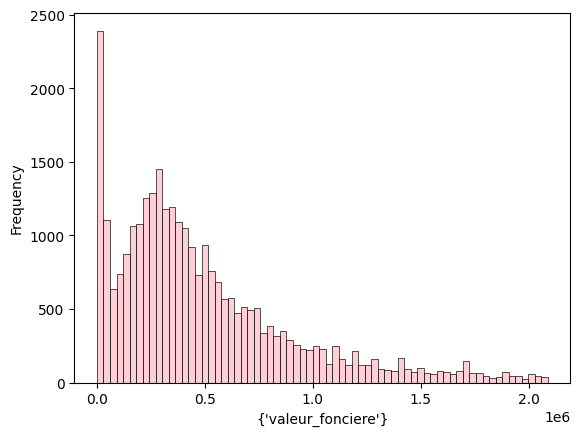

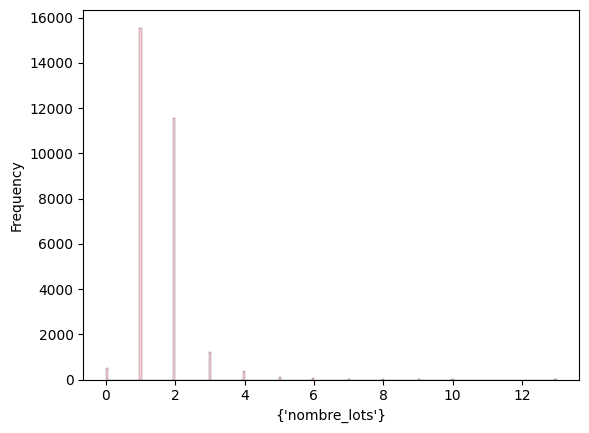

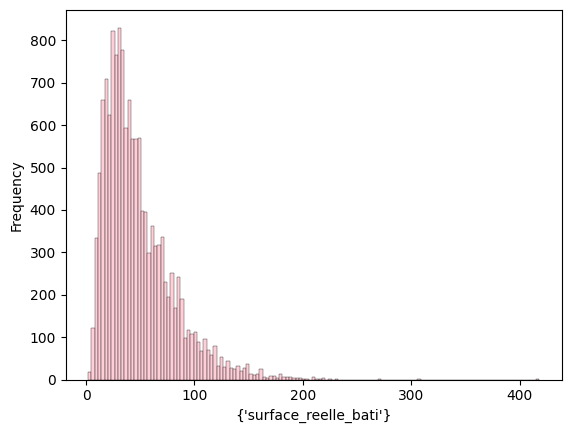

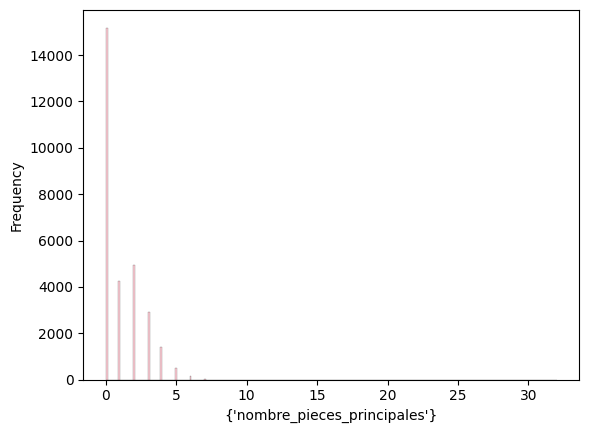

In [130]:
# Histogram of property prices
for x in numerical_columns:
    sns.histplot(paris[x], color='pink')
    plt.xlabel({x})
    plt.ylabel("Frequency")
    plt.show()

apres avoir supprimé les valeurs abérantes: les courbe de distribution paraissent bien plus lisible. Pour la distribution de la valeure foncière et la surface ont remarque que la courbe de distribution est assez symetrique ont fera donc le choix de remplacer les valeurs nulles par la moyenne de cette colonne, les autre valeur numérique seront remplacées par la mediane

In [131]:
#on remplace par la moyenne car les courbe sont presque symetrique 
paris[['valeur_fonciere', 'surface_reelle_bati']] = paris[['valeur_fonciere', 'surface_reelle_bati']].fillna(paris[['valeur_fonciere', 'surface_reelle_bati']].mean())

#on remplace par la mediane car les courbe sont presque asymetrique 
paris[['nombre_pieces_principales', 'nombre_lots']] = paris[['nombre_pieces_principales', 'nombre_lots']].fillna(paris[['nombre_pieces_principales', 'nombre_lots']].median())


### 2. Valeurs catégorique:

Pour des colonnes comme type de local il est judicieux de remplacer les valeurs manquantes par la valeur la plus fréquente car beaucoup de colonnes sont manquantes:


In [132]:
paris['code_type_local'] = paris['code_type_local'].fillna(paris['code_type_local'].mode()[0])
paris['type_local'] = paris['type_local'].fillna(paris['type_local'].mode()[0])

Pour les autre valeurs manquante on peux supprimer toutes les lignes car les valeurs manquantes sont rare:

In [220]:
paris = paris.dropna(subset=['adresse_numero', 'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'longitude', 'latitude'])

Nous allons maintenant nous debarasser des lignes dupliquées

In [134]:
paris.drop_duplicates()
paris.shape

(29458, 20)

Ce code permet de repeter le processus pour les autres fichiers grace a une boucle for. Nous enregistrerons un fichier avec les données regroupé sous le nom idf_nettoye.csv

In [ ]:
# Liste des fichiers
files = [
    "data/75_2024.csv", "data/77_2024.csv", "data/78_2024.csv", "data/91_2024.csv", "data/92_2024.csv", "data/93_2024.csv", "data/94_2024.csv", "data/95_2024.csv",
    "data/75_2023.csv", "data/77_2023.csv", "data/78_2023.csv", "data/91_2023.csv", "data/92_2023.csv", "data/93_2023.csv", "data/94_2023.csv", "data/95_2023.csv",
    "data/75_2022.csv", "data/77_2022.csv", "data/78_2022.csv", "data/91_2022.csv", "data/92_2022.csv", "data/93_2022.csv", "data/94_2022.csv", "data/95_2022.csv"
]

# Initialisation d'une liste pour stocker les DataFrames nettoyés
cleaned_dataframes = []

# Boucle pour traiter chaque fichier
for file in files:
    print(f"Processing {file}...")
    df = pd.read_csv(file)  # Charger le fichier CSV

    # Calcul du pourcentage de valeurs manquantes
    missing_percentage = (df.isna().sum() / len(df)) * 100

    # Sélectionner les colonnes à conserver
    columns_to_keep = missing_percentage[missing_percentage <= 80].index
    df = df[columns_to_keep]

    # Supprimer les colonnes "lot" sauf "nombre_lots"
    columns_to_drop = ["lot1_numero", "lot1_surface_carrez", "lot2_numero","code_nature_culture","nature_culture","surface_terrain"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    # Exclure les lignes où type_local est "Local industriel, commercial ou assimilé"
    if "type_local" in df.columns:
        df = df[df['type_local'] != "Local industriel. commercial ou assimilé"]

    # Gestion des outliers pour "valeur_fonciere"
    if "valeur_fonciere" in df.columns:
        q1 = df['valeur_fonciere'].quantile(0.25)
        q3 = df['valeur_fonciere'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df['valeur_fonciere'] >= lower_bound) & (df['valeur_fonciere'] <= upper_bound)]

    # Remplacer les valeurs manquantes
    if "valeur_fonciere" in df.columns and "surface_reelle_bati" in df.columns:
        df[['valeur_fonciere', 'surface_reelle_bati']] = df[['valeur_fonciere', 'surface_reelle_bati']].fillna(
            df[['valeur_fonciere', 'surface_reelle_bati']].mean()
        )
    if "nombre_pieces_principales" in df.columns and "nombre_lots" in df.columns:
        df[['nombre_pieces_principales', 'nombre_lots']] = df[['nombre_pieces_principales', 'nombre_lots']].fillna(
            df[['nombre_pieces_principales', 'nombre_lots']].median()
        )
    if "code_type_local" in df.columns:
        df['code_type_local'] = df['code_type_local'].fillna(df['code_type_local'].mode()[0])
    if "type_local" in df.columns:
        df['type_local'] = df['type_local'].fillna(df['type_local'].mode()[0])

    # Supprimer les lignes avec des valeurs manquantes dans les colonnes clés
    columns_to_check = ['adresse_numero', 'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'longitude', 'latitude']
    df = df.dropna(subset=[col for col in columns_to_check if col in df.columns])

    # Supprimer les doublons
    df = df.drop_duplicates()

    # Ajouter le DataFrame nettoyé à la liste
    cleaned_dataframes.append(df)

# Combiner tous les DataFrames nettoyés en un seul
df= pd.concat(cleaned_dataframes, ignore_index=True)

# Sauvegarder le résultat dans un fichier
df.to_csv("idf_nettoyee.csv", index=False)
print("Data cleaning complete. Combined file saved as 'idf_nettoyee.csv'.")


In [136]:
df.isna().sum()

id_mutation                  0
date_mutation                0
numero_disposition           0
nature_mutation              0
valeur_fonciere              0
adresse_numero               0
adresse_nom_voie             0
adresse_code_voie            0
code_postal                  0
code_commune                 0
nom_commune                  0
code_departement             0
id_parcelle                  0
nombre_lots                  0
code_type_local              0
type_local                   0
surface_reelle_bati          0
nombre_pieces_principales    0
longitude                    0
latitude                     0
dtype: int64

## 3. Data Mining

Nous allons essayer de tirer de nouvelles informations à partir des colonnes deja présentes

In [137]:
df=pd.read_csv("idf_nettoyee.csv")

### a. La Date

Il est important d'exploiter la colonne date afin d'en tirer le mois et l'année:

In [138]:
#on convertit en format date
df['date_mutation'] = pd.to_datetime(df['date_mutation'], errors='coerce')
#on extrait le mois et l'année des dates
df['annee'] = df['date_mutation'].dt.year
df['mois'] = df['date_mutation'].dt.month
df['trimestre_mutation'] = df['date_mutation'].dt.quarter


### b. Le Prix Par M²

Le prix par mètre carré peut etre extrait à partir de la valeur foncière et de la surface bati:

In [147]:
# Calcul du prix moyen par m²
df['prix_m2'] = df['valeur_fonciere'] / df['surface_reelle_bati']

Q1 = df['prix_m2'].quantile(0.25)
Q3 = df['prix_m2'].quantile(0.75)
IQR = Q3 - Q1
seuil_bas = Q1 - 1.5 * IQR
seuil_haut = Q3 + 1.5 * IQR
transactions_sans_outliers = df[(df['prix_m2'] >= seuil_bas) & (df['prix_m2'] <= seuil_haut)]


### c. La Valeur Foncière Moyenne par commune

La valeur foncière moyenne par commune peut etre utile pour analyser le cout moyen par commune:

In [140]:
# Calculer la valeur foncière moyenne par commune
valeur_fonciere_moyenne = df.groupby('nom_commune')['valeur_fonciere'].mean()

# Assigner la valeur foncière moyenne à chaque ligne du DataFrame original
df['valeur_fonciere_moyenne'] = df['nom_commune'].map(valeur_fonciere_moyenne)

### d. Gamme de transactions

Nous allons catégoriser chaque bien immobilier en fonction de sa gamme de prix: 

In [ ]:
# Définition des catégories de prix
bins = [0, 100000, 300000, 600000, np.inf]
labels = ['Bas de gamme', 'Milieu de gamme', 'Haut de gamme', 'Luxe']
# Catégorisation
df['classe_prix'] = pd.cut(df['valeur_fonciere'], bins=bins, labels=labels, right=False)

### d. Nombre de transactions par commune

Cet donnée peut temoigner de l'attractivité d'une commune

In [142]:
# Calculer le nombre de transactions par commune et par année
transactions_par_commune = df.groupby(['nom_commune', 'annee']).size()

# Réinitialiser l'index pour transformer en DataFrame
transactions_par_commune = transactions_par_commune.reset_index(name='densité_transaction')

# Fusionner avec le DataFrame original pour ajouter la colonne 'densité_transaction'
df = df.merge(transactions_par_commune, on=['nom_commune', 'annee'], how='left')



### l'attractivité

In [144]:
# Normalisation des critères
df['prix_m2_norm'] = (df['prix_m2'] - df['prix_m2'].min()) / (df['prix_m2'].max() - df['prix_m2'].min())
df['densité_norm'] = (df['densité_transaction'] - df['densité_transaction'].min()) / (df['densité_transaction'].max() - df['densité_transaction'].min())

# Calcul du score (pondération ajustable)
df['score_attractivite'] = 0.7 * df['prix_m2_norm'] + 0.3 * df['densité_norm']



### f. Distance de Paris

Notre etude se porte sur la valeur d'un bien immobilier en Ile de France, sa distance avec le coeur Paris est evidemment à prendre en compte dans notre etude, c'est donc pour cela qu'une colonne: distance_paris sera ajjouté a chaque bien immobilier:

In [ ]:
from geopy.distance import geodesic

# Coordonnées de référence (Paris)
paris_coords = (48.8566, 2.3522)

# Calcul de la distance
def calculate_distance(lat, lon):
    try:
        return geodesic(paris_coords, (lat, lon)).kilometers
    except:
        return np.nan

df['distance_paris'] = df.apply(lambda row: calculate_distance(row['latitude'], row['longitude']), axis=1)


### g. La Catégorie de surface

On etudiera les differentes surface pour essayyer de trouver des tendances par regions

In [ ]:
# Définition des catégories de surface
bins = [0, 50, 100, 150, np.inf]
labels = ['Petit logement', 'Logement moyen', 'Grand logement', 'Très grand logement']

# Catégorisation
df['categorie_surface'] = pd.cut(df['surface_reelle_bati'], bins=bins, labels=labels, right=False)


### Evolutionn du prix au m2

In [ ]:

# Filtrer les données nécessaires pour 2022 et 2024
df_filtered = df[df['annee'].isin([2022, 2024])]

# Calculer le prix moyen au m² pour 2022 et 2024 par commune et département
prix_par_annee = df_filtered.groupby(['code_departement', 'nom_commune', 'annee'])['prix_m2'].mean().unstack()

# Ajouter les colonnes pour l'évolution absolue et relative
prix_par_annee['augmentation_absolue'] = prix_par_annee[2024] - prix_par_annee[2022]
prix_par_annee['augmentation_relative'] = (
    (prix_par_annee[2024] - prix_par_annee[2022]) / prix_par_annee[2022] * 100
)

# Joindre les résultats de l'évolution avec le DataFrame original
df = df.merge(prix_par_annee[['augmentation_absolue', 'augmentation_relative']], 
              on=['code_departement', 'nom_commune'], how='left')


## 4 Visualisation et exploration des données

#### a.Les transactions

Jettons un coup d'oeil sur les 10 villes avec le plus de transactions en ile de France:

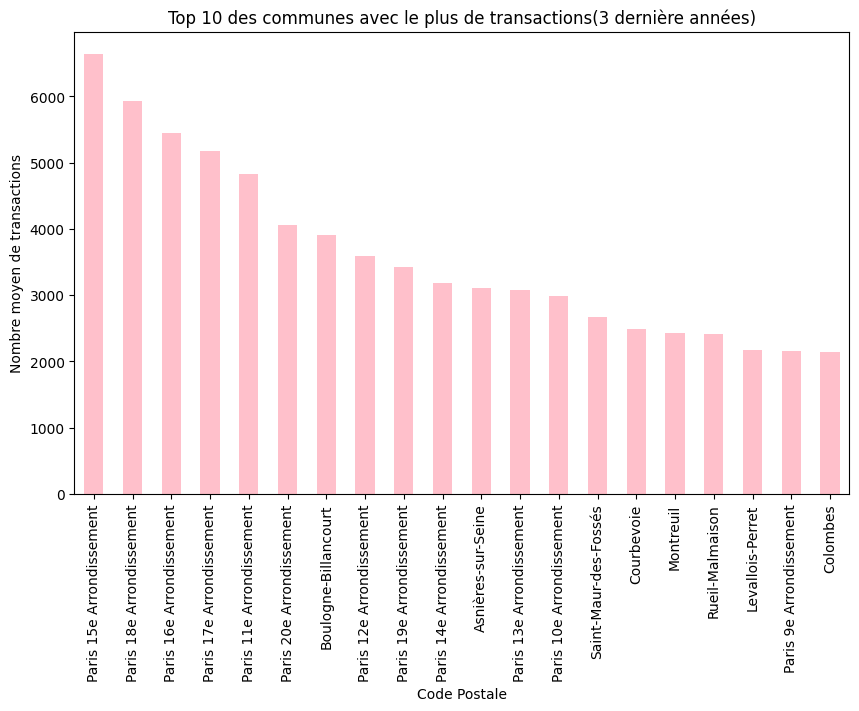

In [ ]:
avg_price_region = df.groupby('nom_commune')['densité_transaction'].mean()

# Plot top 10 regions with highest average property prices
top_regions = avg_price_region.sort_values(ascending=False).head(20)
top_regions.plot(kind='bar', figsize=(10, 6), color='pink')
plt.title("Top 10 des communes avec le plus de transactions(3 dernière années)")
plt.xlabel("Code Postale")
plt.ylabel("Nombre moyen de transactions")
plt.show()

Sans surprise on remarque que c'est Paris avec le 15ème arrondissement largement en tête.

### Essayons de defiler pour voir les villes avec le plus de transactions par departement:

In [ ]:
@interact(annee=df['annee'].unique())
def plot_transactions(annee):
    data = df[df['annee'] == annee]
    transactions_par_mois = data.groupby('mois').size()
    plt.figure(figsize=(10, 6))
    plt.bar(transactions_par_mois.index, transactions_par_mois.values, color='skyblue')
    plt.title(f"Volume des Transactions en {annee}")
    plt.xlabel("Mois")
    plt.ylabel("Nombre de Transactions")
    plt.xticks(np.arange(1, 13, step=1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



interactive(children=(Dropdown(description='annee', options=(2024, 2023, 2022), value=2024), Output()), _dom_c…

### Densité de transaction par dep

In [227]:
@interact(annee=df['annee'].unique())
def plot_densite_transactions(annee):
    # Filtrer les données pour l'année sélectionnée
    data = df[df['annee'] == annee]
    
    # Calculer la densité moyenne des transactions par département
    densite_par_departement = data.groupby('code_departement')['densité_transaction'].mean()
    
    # Garder uniquement les départements ayant des données pour cette année
    departements_avec_donnees = densite_par_departement.dropna()
    
    # Sélectionner les 8 départements avec les densités les plus élevées
    top_8_departements = departements_avec_donnees.nlargest(8)
    
    # Affichage du graphique
    plt.figure(figsize=(10, 6))
    
    # Utiliser un axe catégorique pour les départements (c'est-à-dire des labels)
    plt.bar(top_8_departements.index.astype(str), top_8_departements.values, color='orange')
    
    # Titre et labels des axes
    plt.title(f"Densité Moyenne des Transactions par Département ({annee})")
    plt.xlabel("Département")
    plt.ylabel("Densité Moyenne")
    
    # Rotation des labels sur l'axe des X pour une meilleure lisibilité
    plt.xticks(rotation=45)
    
    # Affichage de la grille
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Affichage du graphique
    plt.show()



interactive(children=(Dropdown(description='annee', options=(2024, 2023, 2022), value=2024), Output()), _dom_c…

### Attractivité


In [ ]:

# Liste des départements d'Île-de-France
departements_idf = [75, 77, 78, 91, 92, 93, 94, 95]

@interact(departement=departements_idf)
def top_communes_par_departement(departement):
    data = df[df['code_departement'] == departement]
    if data.empty:
        print(f"Aucune donnée pour le département {departement}.")
        return
    
    top_communes = data.groupby('nom_commune')['score_attractivite'].mean().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    plt.barh(top_communes.index, top_communes.values, color='lightgreen')
    plt.title(f"Top 10 Communes par Score d'Attractivité - Département {departement}")
    plt.xlabel("Score d'Attractivité")
    plt.ylabel("Commune")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


interactive(children=(Dropdown(description='departement', options=(75, 77, 78, 91, 92, 93, 94, 95), value=75),…

### Prix metre carrée

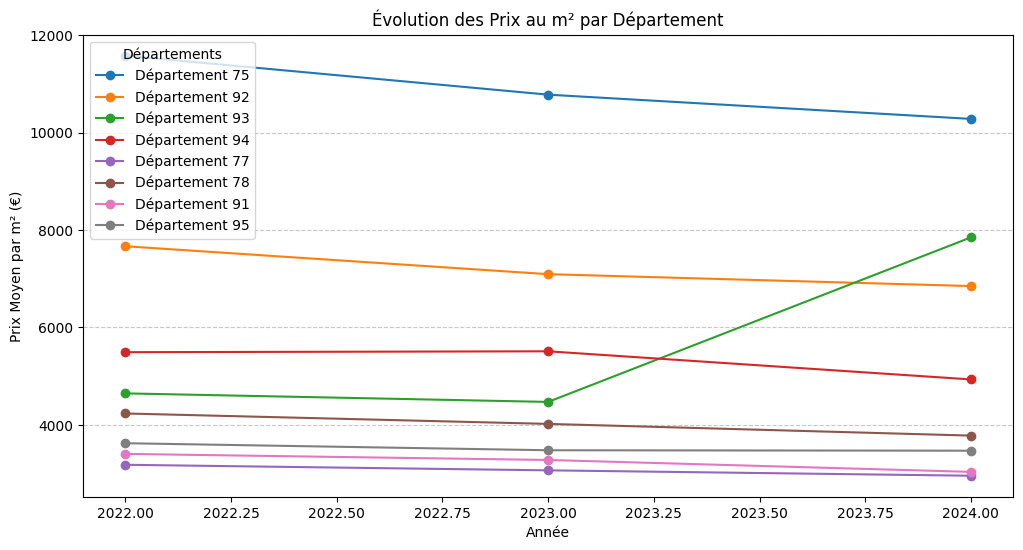

In [149]:
def plot_prix_comparatif(departements):
    data = df[df['code_departement'].isin(departements)]
    prix_m2 = data.groupby(['annee', 'code_departement'])['prix_m2'].mean().unstack()
    
    plt.figure(figsize=(12, 6))
    for dep in departements:
        plt.plot(prix_m2.index, prix_m2[dep], marker='o', label=f"Département {dep}")
    
    plt.title("Évolution des Prix au m² par Département")
    plt.xlabel("Année")
    plt.ylabel("Prix Moyen par m² (€)")
    plt.legend(title="Départements")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Exemple d'appel
plot_prix_comparatif([75, 92, 93, 94, 77, 78, 91, 95])


In [ ]:

# Fonction pour afficher le tableau interactif avec les augmentations et la distance à Paris
@interact(departement=df['code_departement'].unique())
def afficher_tableau(departement):
    # Filtrer les données par département
    data_departement = df[df['code_departement'] == departement]
    
    # Trier les données par augmentation absolue, mais aussi par distance à Paris
    data_departement = data_departement.sort_values(by=['augmentation_absolue', 'distance_paris'], ascending=[False, True])
    
    # Sélectionner les top 10 villes en fonction de l'augmentation absolue
    top_10_villes = data_departement[['nom_commune', 'augmentation_absolue', 'augmentation_relative', 'distance_paris']].drop_duplicates('nom_commune').head(10)
    
    # Créer un tableau propre pour affichage
    tableau = top_10_villes.copy()
    tableau.rename(columns={
        'augmentation_absolue': 'Augmentation Absolue (€)',
        'augmentation_relative': 'Augmentation Relative (%)',
        'distance_paris': 'Distance à Paris (km)'
    }, inplace=True)
    
    # Afficher les résultats du top 10
    display(tableau)
 # Afficher un camembert pour la répartition des types de bien en fonction du nombre de transactions
    for commune in top_10_villes['nom_commune']:
        data_commune = data_departement[data_departement['nom_commune'] == commune]
        
        # Calculer la répartition du type de bien en fonction du nombre de transactions
        repartition_type_bien = data_commune.groupby('type_local')['densité_transaction'].sum().reset_index()
        
        # Vérifier si la répartition a des valeurs avant d'afficher le camembert
        if not repartition_type_bien.empty:
            plt.figure(figsize=(3, 3))
            plt.pie(repartition_type_bien['densité_transaction'], labels=repartition_type_bien['type_local'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", n_colors=len(repartition_type_bien)))
            plt.title(f"{commune}")
            plt.axis('equal')  # Pour un cercle parfait
            plt.show()
        else:
            print(f"\nAucune donnée de répartition des types de bien pour {commune}.")





interactive(children=(Dropdown(description='departement', options=(75, 77, 78, 91, 92, 93, 94, 95), value=75),…